In [2]:
import h5py
import numpy as np
import pandas as pd
import pickle
import common
import matplotlib.pyplot as plt
import sys
import seaborn as sns
sys.path.insert(1, './ob_raw/')
from model import OB_model, CustomGen
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import AdaBoostRegressor
from keras import optimizers, initializers
from keras.layers import Dense, MaxPooling2D, Dropout, Flatten, Conv2D, Conv1D, Input, concatenate
from keras import regularizers
import keras
from keras.models import Model

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [60]:
with h5py.File("./116.203.79.48/data/btc_insample/prep_dataPIC.h5", "r") as data:
    with h5py.File("./116.203.79.48/data/btc_insample/result.h5", "r") as targets:
        with h5py.File("./116.203.79.48/data/btc_insample/prep_data3.h5", "r") as hand_data:
            image_input = Input(shape=(10, 62, 1))
            hand_input = Input(shape=(7,))
            
            conv1 = Conv2D(20, kernel_size=2, activation='relu')(image_input)
            maxp1 = MaxPooling2D(pool_size=(1,2))(conv1)
            conv2 = Conv2D(40, kernel_size=2, activation='relu')(maxp1)
            maxp2 = MaxPooling2D(pool_size=(1,2))(conv2)
            conv3 = Conv2D(80, kernel_size=2, activation='tanh')(conv2)
            maxp3 = MaxPooling2D(pool_size=(1,2))(conv3)
            drop = Dropout(0.2)(maxp3)
            flatten = Flatten()(maxp3)
            
            merged = concatenate([flatten, hand_input])
            d1 = Dense(50)(merged)
            d2 = Dense(20)(d1)
            out = Dense(1, activation='linear')(d2)
            
            model = Model(inputs=[image_input, hand_input], outputs=[out])
            model.compile(optimizer=optimizers.RMSprop(lr=0.001), loss='mse')
            model.summary()
            l = data["data"].shape[0] // 100
            
            X = [data["data"][:l], hand_data["data"][:l]]
            y = np.array(targets["Return"]["Res"][:l]) * 100
            model.fit(X,y,
                      shuffle="batch", 
                      batch_size = 32,
                      epochs=3)

Model: "model_15"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_39 (InputLayer)           (None, 10, 62, 1)    0                                            
__________________________________________________________________________________________________
conv2d_58 (Conv2D)              (None, 9, 61, 20)    100         input_39[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_58 (MaxPooling2D) (None, 9, 30, 20)    0           conv2d_58[0][0]                  
__________________________________________________________________________________________________
conv2d_59 (Conv2D)              (None, 8, 29, 40)    3240        max_pooling2d_58[0][0]           
___________________________________________________________________________________________

In [61]:
with h5py.File("./116.203.79.48/data/btc_insample/prep_dataPIC.h5", "r") as data:
    with h5py.File("./116.203.79.48/data/btc_insample/prep_data3.h5", "r") as hand_data:
        predictions = model.predict([data["data"][:l], hand_data["data"][:l]], verbose = 1)

78973/78973 [==============================] - 9s 113us/step


(78973,) (78973,)
[[1.         0.00984048]
 [0.00984048 1.        ]]
score: 0.009957609838667862
benchmark: 0.009958053649413632


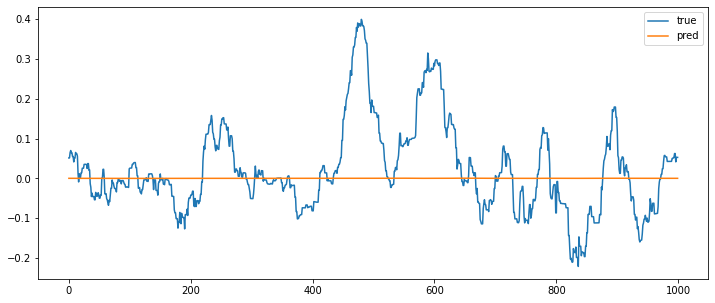

In [62]:
with h5py.File("./116.203.79.48/data/btc_insample/result.h5", "r") as targets:
    ll = 1000
    rr = 2000
    predictions = predictions.reshape(-1)
    y = np.array(targets["Return"]["Res"][:l]) * 100
    print(y.shape, predictions.shape)
    
    print(np.corrcoef(predictions, y))
    print("score:", np.sum((predictions-y)**2) / y.shape[0])
    print("benchmark:", np.sum(y**2) / y.shape[0])
    
    plt.figure(figsize=(12,5))
    plt.plot(y[ll:rr], label = "true")
    plt.plot(predictions[ll:rr], label="pred")
    plt.legend()

(7897313, 57)


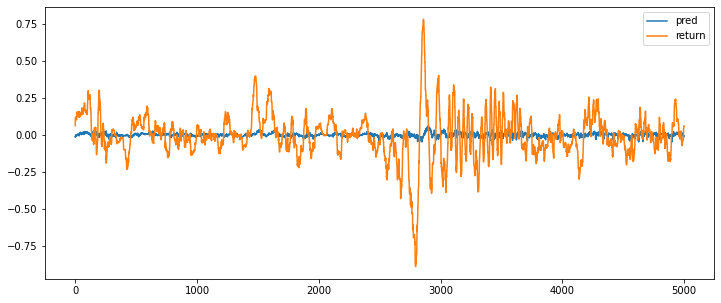

corr_coef:  0.13339335783903458
improvment, %:  0.01779991356843258


In [5]:
predictions = model.predict(X_train)
scoring(predictions, y_train)

(1974329, 57)


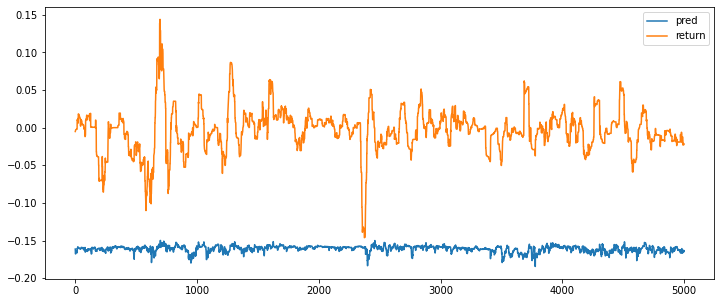

[[1.         0.08965255]
 [0.08965255 1.        ]]
0.032005225373989296
0.005459577795465008


In [4]:
with h5py.File("./116.203.79.48/data/btc_outsample/prep_data2.h5", "r") as data:
    with h5py.File("./116.203.79.48/data/btc_outsample/result.h5", "r") as targets:
        with h5py.File("./116.203.79.48/data/btc_outsample/prep_data3.h5", "r") as data3:
            t = data["data"].shape[0]
            X_test = np.array(data["data"][:t])
            X_test = X_test.reshape(X_test.shape[0], -1)
            X_test2 = np.array(data3["data"][:t])
            X_test = np.concatenate([X_test, X_test2.reshape(X_test2.shape[0], -1)], axis = 1)
            y_test = np.array(targets["Return"]["Res"][:X_test.shape[0]]) * 100
            print(X_test.shape)
            
            prediction = model.predict(X_test)
            plt.figure(figsize=(12,5))
            plt.plot(prediction[l:r], label = "pred")
            plt.plot(y_test[l:r], label = "return")
            plt.legend()
            plt.show()
            print(np.corrcoef(prediction, y_test))
            print(np.sum((prediction-y_test)**2) / y_test.shape[0])
            print(np.sum(y_test**2) / y_test.shape[0])

In [4]:

    
def fitting(data, targets, model):
    t = data["data"].shape[0]
    
    #gen = TimeseriesGenerator(X_train, y_train, length = 1, batch_size = 512)
    
    #model = MLPRegressor(hidden_layer_sizes=(10), activation='relu')
    model.fit(X_train, y_train)#, epochs=10, workers=8)
    predictions = model.predict(X_train)
    scoring(predictions, y_train)
    
    
def testing(data, targets, model):
    X_test = np.array(data["data"])
    y_test = np.array(targets["Return"]["Res"])
    print(X_test.shape, y_test.shape)
    X_test = X_test.reshape(X_test.shape[0], -1)
    predictions = model.predict(X_test)
    scoring(predictions, y_test)

(7897313, 25, 2)


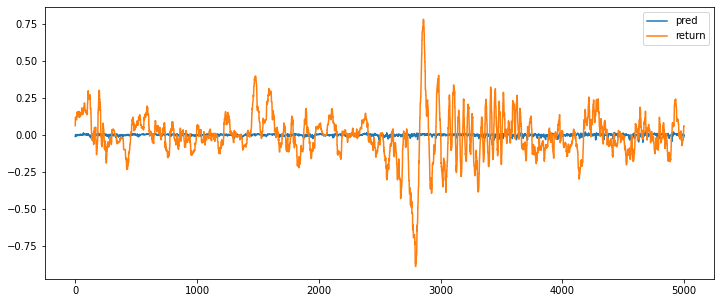

corr_coef:  0.11951082313398513
improvment, %:  0.014286092229615188


In [35]:

        model = Ridge()
        fitting(data, targets, model)

(1974329, 25, 2) (1974329,)


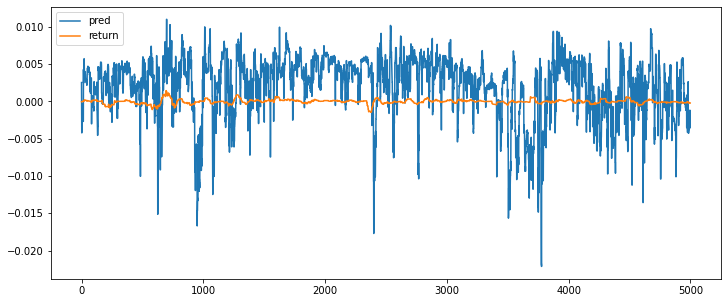

corr_coef:  0.08366529220875354
improvment, %:  -117.51177614339231


In [36]:
with h5py.File("./116.203.79.48/data/btc_outsample/prep_data2.h5", "r") as data:
    with h5py.File("./116.203.79.48/data/btc_outsample/result.h5", "r") as targets:
        testing(data, targets, model)

In [4]:
from keras.layers import Dense, MaxPooling2D, Dropout, Flatten, Conv2D, Conv1D
import keras
model = keras.Sequential()
input_shape = (50,)
model.add(Flatten(input_shape = (3, 50)))
model.add(Dense(30))
model.add(Dense(15))
model.add(Dense(1,  activation = 'linear'))
model.compile(loss='mse', optimizer='sgd')


In [5]:
predictions = np.array(model.predict(X_train)).reshape(-1)

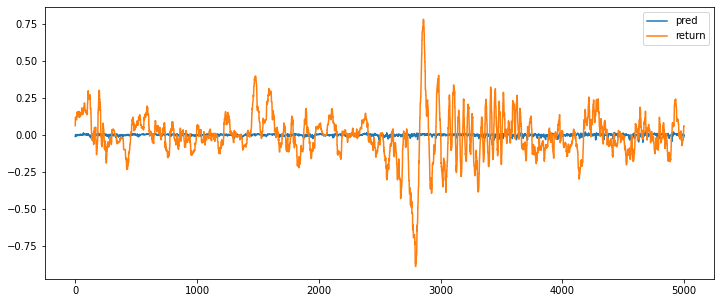

[[1.         0.11951082]
 [0.11951082 1.        ]]
improvment, %:  0.014286092229615188


In [17]:
np.sum(y_train**2 / y_train.shape[0])

0.00440055592871967